In [1]:
import pandas as pd
import numpy as np
import json
import os
import requests
from config import api_key, postgres_pass#, heroku_pass, heroku_URI
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import joblib
import tensorflow as tf
import keras
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
#Select Ticker
ticker = 'msft'
tick = yf.Ticker(ticker)
# pull Ticker details from Yahoo Finance
history = tick.history(period="max")

In [3]:
# Yahoo API

#ticvker = 'kim'
#endpoint = "/v11/finance/quoteSummary/"
#url = "https://yfapi.net" + endpoint + ticker
#querystring = {"modules":"defaultKeyStatistics"}

#headers = {
#    'x-api-key': api_key
#    }

#response = requests.request("GET", url, headers=headers, params=querystring)

#tick_resp = response
#tick_resp.json()['quoteSummary']['result'][0]['defaultKeyStatistics']

In [4]:
history.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [5]:
len(history)

9084

In [6]:
history.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [7]:
history.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

In [8]:
history.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,9084.000000,9084.000000,9084.000000,9084.000000,9.084000e+03,9084.000000,9084.000000
mean,36.275610,36.648222,35.891539,36.285559,5.874657e+07,0.002482,0.001871
std,60.026532,60.604230,59.406873,60.043727,3.845175e+07,0.042193,0.059788
min,0.055949,0.058143,0.055949,0.057046,2.304000e+06,0.000000,0.000000
25%,2.560896,2.599618,2.546086,2.577866,3.460562e+07,0.000000,0.000000
50%,18.941177,19.143998,18.735764,18.948538,5.203020e+07,0.000000,0.000000
75%,29.290973,29.603004,28.892207,29.244791,7.265020e+07,0.000000,0.000000
max,343.908878,348.948476,341.493913,342.402008,1.031789e+09,3.000000,2.000000


In [9]:
history.to_csv('history_data.csv', index=False)

In [10]:
df_hist = pd.read_csv('history_data.csv')
df_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,0.055949,0.064177,0.055949,0.061434,1031788800,0.0,0.0
1,0.061434,0.064725,0.061434,0.063628,308160000,0.0,0.0
2,0.063628,0.065274,0.063628,0.064725,133171200,0.0,0.0
3,0.064725,0.065274,0.062531,0.063079,67766400,0.0,0.0
4,0.063079,0.063628,0.061434,0.061982,47894400,0.0,0.0
...,...,...,...,...,...,...,...
9079,298.890015,300.140015,294.899994,299.160004,28351200,0.0,0.0
9080,299.799988,305.000000,298.769989,304.059998,27599700,0.0,0.0
9081,300.510010,303.230011,297.720001,299.489990,25715400,0.0,0.0
9082,299.140015,304.200012,298.320007,304.100006,24484500,0.0,0.0


In [11]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [12]:
# looking at a 28-day stock history
lags = 500

# looking at a 2-day stock forecast
steps = 2

In [26]:
# Number of weeks of lag features
y = history.drop(columns=['Dividends', 'Stock Splits'])
X = make_lags(y, lags=lags).fillna(0.0)
X

y_lag_1                                                    \
                  Open        High         Low       Close        Volume   
Date                                                                       
1986-03-13    0.000000    0.000000    0.000000    0.000000  0.000000e+00   
1986-03-14    0.055949    0.064177    0.055949    0.061434  1.031789e+09   
1986-03-17    0.061434    0.064725    0.061434    0.063628  3.081600e+08   
1986-03-18    0.063628    0.065274    0.063628    0.064725  1.331712e+08   
1986-03-19    0.064725    0.065274    0.062531    0.063079  6.776640e+07   
...                ...         ...         ...         ...           ...   
2022-03-21  295.369995  301.000000  292.730011  300.429993  4.331700e+07   
2022-03-22  298.890015  300.140015  294.899994  299.160004  2.835120e+07   
2022-03-23  299.799988  305.000000  298.769989  304.059998  2.759970e+07   
2022-03-24  300.510010  303.230011  297.720001  299.489990  2.571540e+07   
2022-03-25  299.140015  304.200012  298.320007  304.100006  2.448450e+07   

               y_lag_2                                                    ...  \
                  Open        High         Low       Close        Volume  ...   
Date                                                                      ...   
1986-03-13    0.000000    0.000000    0.000000    0.000000  0.000000e+00  ...   
1986-03-14    0.000000    0.000000    0.000000    0.000000  0.000000e+00  ...   
1986-03-17    0.055949    0.064177    0.055949    0.061434  1.031789e+09  ...   
1986-03-18    0.061434    0.064725    0.061434    0.063628  3.081600e+08  ...   
1986-03-19    0.063628    0.065274    0.063628    0.064725  1.331712e+08  ...   
...                ...         ...         ...         ...           ...  ...   
2022-03-21  293.290009  295.609985  289.369995  295.220001  3.081660e+07  ...   
2022-03-22  295.369995  301.000000  292.730011  300.429993  4.331700e+07  ...   
2022-03-23  298.890015  300.140015  294.899994  299.160004  2.835120e+07  ...   
2022-03-24  299.799988  305.000000  298.769989  304.059998  2.759970e+07  ...   
2022-03-25  300.510010  303.230011  297.720001  299.489990  2.571540e+07  ...   

             y_lag_499                                                  \
                  Open        High         Low       Close      Volume   
Date                                                                     
1986-03-13    0.000000    0.000000    0.000000    0.000000         0.0   
1986-03-14    0.000000    0.000000    0.000000    0.000000         0.0   
1986-03-17    0.000000    0.000000    0.000000    0.000000         0.0   
1986-03-18    0.000000    0.000000    0.000000    0.000000         0.0   
1986-03-19    0.000000    0.000000    0.000000    0.000000         0.0   
...                ...         ...         ...         ...         ...   
2022-03-21  149.009688  152.092985  146.505733  146.996704  57042300.0   
2022-03-22  149.687241  157.699892  147.301115  157.336563  63420300.0   
2022-03-23  156.521514  161.804366  153.732803  154.862045  77927200.0   
2022-03-24  150.237117  154.901342  148.096491  149.363190  57969900.0   
2022-03-25  149.117717  152.672343  147.644804  152.456314  49630700.0   

             y_lag_500                                                  
                  Open        High         Low       Close      Volume  
Date                                                                    
1986-03-13    0.000000    0.000000    0.000000    0.000000         0.0  
1986-03-14    0.000000    0.000000    0.000000    0.000000         0.0  
1986-03-17    0.000000    0.000000    0.000000    0.000000         0.0  
1986-03-18    0.000000    0.000000    0.000000    0.000000         0.0  
1986-03-19    0.000000    0.000000    0.000000    0.000000         0.0  
...                ...         ...         ...         ...         ...  
2022-03-21  145.720147  153.830995  145.690690  153.290924  64568100.0  
2022-03-22  149.009688  152.092985  146.505733  

In [27]:
# Number of days forecast
y = y.loc[:, 'Close'] # Targer Variable is Close
y = make_multistep_target(y, steps=steps).dropna()
y

,y_step_1,y_step_2
Date,,
1986-03-13,0.061434,0.063628
1986-03-14,0.063628,0.064725
1986-03-17,0.064725,0.063079
1986-03-18,0.063079,0.061982
1986-03-19,0.061982,0.060337
...,...,...
2022-03-18,300.429993,299.160004
2022-03-21,299.160004,304.059998
2022-03-22,304.059998,299.489990


In [28]:
# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [29]:
model = LinearRegression()
model.fit(X,y)

y_pred = pd.DataFrame(model.predict(X), index=X.index)

C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


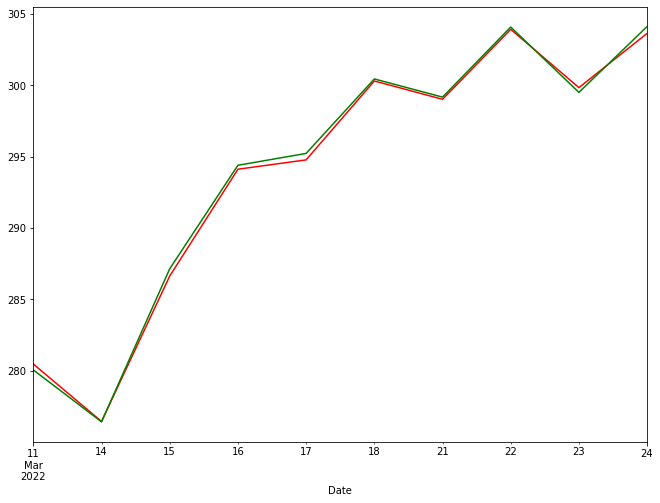

In [33]:
ax = y_pred[0].tail(10).plot(figsize=(11, 8), color='red')
ax = y['y_step_1'].tail(10).plot(figsize=(11, 8), color = 'green')

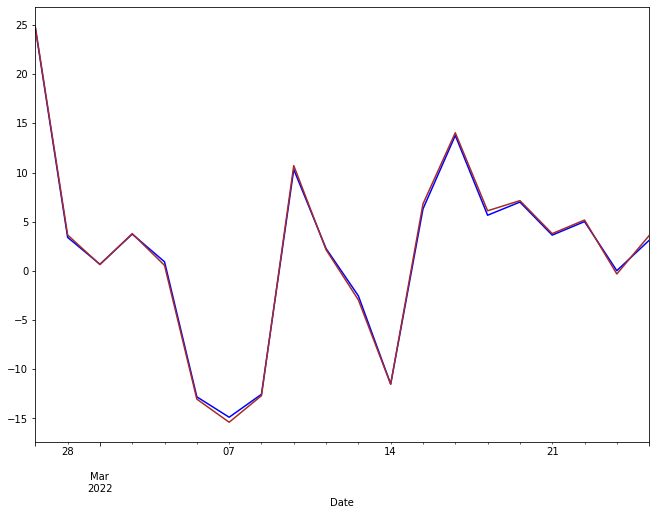

In [19]:
# Delta between Open and Closing Price
profit_pred = - X.y_lag_1['Open'] + y_pred[0]
for i,d in enumerate(profit_pred):
    if i>5:
        act = 'buy'
    else:
        act ='stay'
#    profit_pred.loc[i,0]
        
profit_act = - X.y_lag_1['Open'] + y.y_step_1
ax = profit_pred.tail(20).plot(figsize=(11, 8), color='blue')
ax = profit_act.tail(20).plot(figsize=(11, 8), color='brown')

In [20]:
# Split the preprocessed data into a training and testing dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X)
    
# Scale the data
X_scaled = X_scaler.transform(X)
    
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_scaled[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30

#nn = tf.keras.models.Sequential()
nn = keras.models.Sequential()

# First hidden layer
nn.add(keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()
    
train_size = len(X_scaled)
#train_size
    
batch_size = 32
steps_per_epoch = train_size / batch_size
save_period = 5
save_freq = int(save_period * steps_per_epoch)
    
# Compile the model
nn.compile(loss="mean_absolute_error", optimizer="adam")
    
 # Train the model
fit_model = nn.fit(X_scaled, y, epochs=50, batch_size = batch_size)
    
# Evaluate the model using the test data
model_loss = nn.evaluate(X_scaled, y, verbose=2)
print(f"Loss: {model_loss}")
    
# Calculate Adjusted r-square
#import statsmodels.api as sm
#XaddC = sm.add_constant(X_scaled)
#result = sm.OLS(y, XaddC).fit()
#print(f"R-Squared: {result.rsquared}, R-Squared Adjusted: {result.rsquared_adj}")

C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                200080    
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 202,541
Trainable params: 202,541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
284/284 [==============================] - 1s 2ms/step - loss: 8.3469
Epoch 2/50
284/284 [==============================] - 1s 3ms/step - loss: 4.1877
Epoch 3/50
284/284 [==============================] - 1s 4ms/step - loss: 2.9441
Epoch 4/50
284/284 [==============================] - 1s 2ms/step - los

In [21]:
y_pred = pd.DataFrame(nn.predict(X_scaled), index = X.index)

284/284 [==============================] - 1s 2ms/step


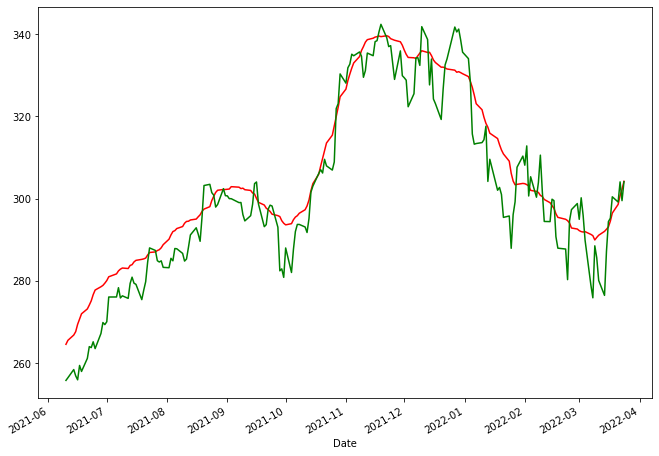

In [22]:
ax = y_pred[0].tail(200).plot(figsize=(11, 8), color='red')
ax = y['y_step_1'].tail(200).plot(figsize=(11, 8), color = 'green')

In [23]:
#len(X[0])

In [24]:
# Split the preprocessed data into a training and testing dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X)
    
# Scale the data
X_scaled = X_scaler.transform(X)
    
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_scaled[0])
hidden_nodes_layer1 = 40
hidden_nodes_layer2 = 20

#nn = tf.keras.models.Sequential()
nn = keras.models.Sequential()

# First hidden layer
nn.add(keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()
    
#train_size = len(X)
#train_size
    
#batch_size = 32
#steps_per_epoch = train_size / batch_size
#save_period = 5
#save_freq = int(save_period * steps_per_epoch)
    
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam")
    
 # Train the model
fit_model = nn.fit(X_scaled, y, epochs=50) #, batch_size = batch_size)
    
# Evaluate the model using the test data
model_loss = nn.evaluate(X_scaled, y, verbose=2)
print(f"Loss: {model_loss}")

C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model: "sequential_1"


C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 40)                100040    
                                                                 
 dense_4 (Dense)             (None, 20)                820       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 100,881
Trainable params: 100,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
284/284 [==============================] - 1s 2ms/step - loss: 277.4922
Epoch 2/50
284/284 [==============================] - 1s 2ms/step - loss: 50.8257
Epoch 3/50
284/284 [==============================] - 1s 2ms/step - loss: 42.5305
Epoch 4/50
284/284 [==============================] - 1s 2ms/step - loss: 24.7454
Epoch

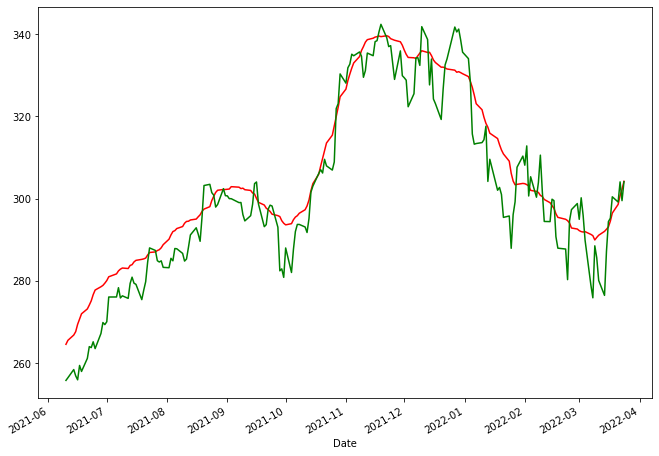

In [25]:
ax = y_pred[0].tail(200).plot(figsize=(11, 8), color='red')
ax = y['y_step_1'].tail(200).plot(figsize=(11, 8), color = 'green')